# Lung 3D segmentation with MONAI

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[transformers]"
!pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!pip install -q "monai-weekly[mlflow, pynrrd]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import UNETR
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
from tqdm import tqdm


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print_config()

MONAI version: 0.9.dev2224
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: cb6ecb1a22042d4a559b864e74c64d99352dcf7c
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.19.4
mlflow version: 1.26.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

root_dir = "/content/drive/My Drive/"
project_folder = "FYP/MONAI_Lung/"
data_loc = "FYP/MONAI_Lung/Data/Task06_Lung/"

data_dir = root_dir + data_loc


def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  os.chdir(root_dir + project_folder)
  print('\nYour working directory was changed to ' + root_dir + project_folder)

create_and_set_working_directory(project_folder)

Mounted at /content/drive

Your working directory was changed to /content/drive/My Drive/FYP/MONAI_Lung/


# Lung Dataset loading

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:-6]

In [ ]:
set_determinism(seed=0)

# Training and validation transforms

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# Check the transforms in the Dataloader

image shape: torch.Size([512, 386, 450]), label shape: torch.Size([512, 386, 450])


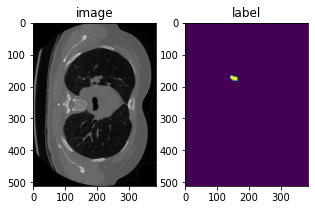

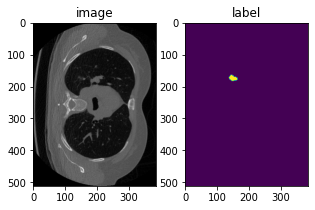

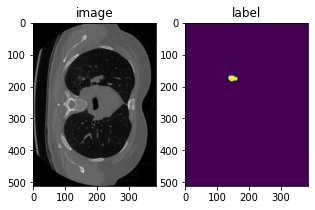

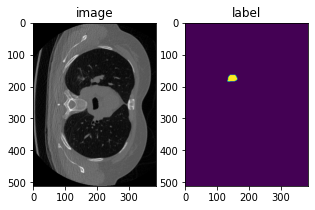

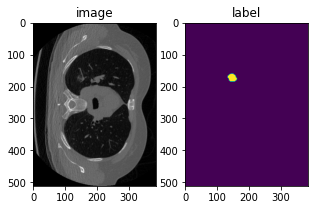

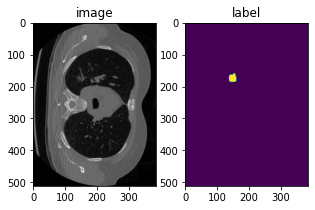

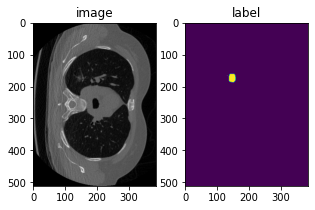

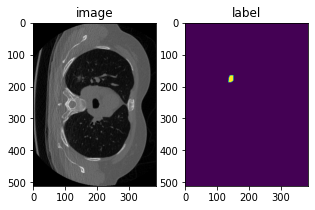

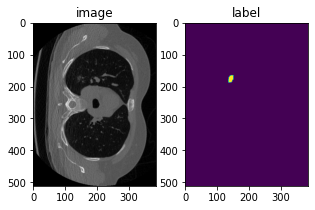

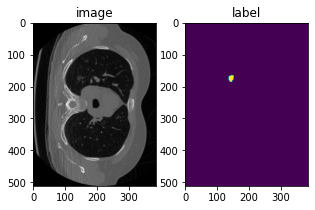

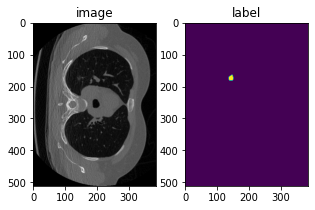

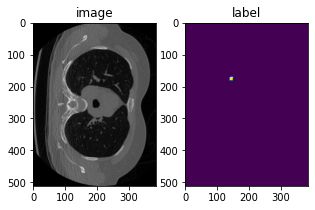

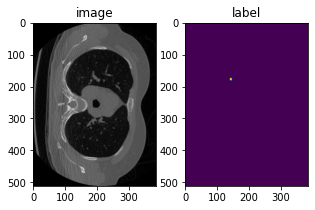

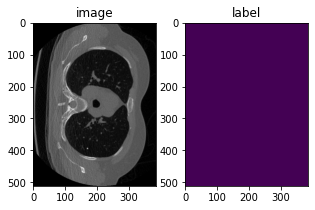

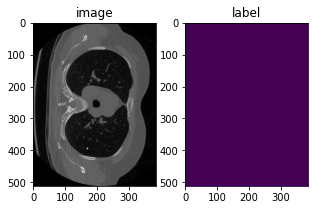

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
for i in range(315,330):
  plt.figure(figsize=(5, 3))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(image[:, :, i], cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label[:, :, i])
plt.show()

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 3/3 [00:09<00:00,  3.33s/it]


# Create the model, with the loss and optimiser specified too

In [ ]:
from typing import Optional, Sequence, Tuple, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, deprecated_arg, export

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(96, 96, 96),
    feature_size=8,
    hidden_size=384,
    mlp_dim=1536,
    num_heads=6,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Execute custom PyTorch MCNN training process


In [ ]:

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step+1) % 2700 == 0:
          torch.save(
                    model.state_dict(), os.path.join(root_dir, f"UNETR_epoch_{(global_step+1)/27}.pth")
                )
          print("model saved!")

        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 32400
eval_num = 54
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_UNETR.pth")))

# around 6.5k already done

Training (2699 / 32400 Steps) (loss=0.36669): 100%|██████████| 27/27 [00:35<00:00,  1.32s/it]

model saved!


Training (5399 / 32400 Steps) (loss=0.21954): 100%|██████████| 27/27 [00:35<00:00,  1.32s/it]

model saved!


Training (8099 / 32400 Steps) (loss=0.29203): 100%|██████████| 27/27 [00:36<00:00,  1.33s/it]

model saved!


Training (10799 / 32400 Steps) (loss=0.17698): 100%|██████████| 27/27 [00:35<00:00,  1.31s/it]

model saved!


Training (13499 / 32400 Steps) (loss=0.38850): 100%|██████████| 27/27 [00:35<00:00,  1.31s/it]

model saved!


Training (16199 / 32400 Steps) (loss=0.28395): 100%|██████████| 27/27 [00:36<00:00,  1.31s/it]

model saved!


Training (18899 / 32400 Steps) (loss=0.13156): 100%|██████████| 27/27 [00:36<00:00,  1.31s/it]

model saved!


Training (21599 / 32400 Steps) (loss=0.19646): 100%|██████████| 27/27 [00:35<00:00,  1.32s/it]

model saved!


Training (24299 / 32400 Steps) (loss=0.24254): 100%|██████████| 27/27 [00:35<00:00,  1.31s/it]

model saved!


Training (26999 / 32400 Steps) (loss=0.27968): 100%|██████████| 27/27 [00:35<00:00,  1.32s/it]

model saved!


Training (29699 / 32400 Steps) (loss=0.27841): 100%|██████████| 27/27 [00:35<00:00,  1.33s/it]

model saved!


Training (32399 / 32400 Steps) (loss=0.22279): 100%|██████████| 27/27 [00:35<00:00,  1.32s/it]

model saved!


Training (32399 / 32400 Steps) (loss=0.22279): 100%|██████████| 27/27 [00:36<00:00,  1.34s/it]


FileNotFoundError: ignored